# Основы анализа данных в Python

*Алла Тамбовцева*

## Практикум 7. Повторение

### Подготовка данных

Импортируем необходимые библиотеки:
    
* модуль `stats` из `scipy` для статистических вычислений;
* библиотека `pandas` для загрузки данных и работы с датафреймами.

In [1]:
import pandas as pd
import scipy.stats as st

Загрузим данные из файла `Netflix.csv`:

In [2]:
films = pd.read_csv("Netflix.csv")
films.head()

,Title,Genre,Premiere,Runtime,IMDB Score,Language
0,Enter the Anime,Documentary,"August 5, 2019",58.0,2.5,English/Japanese
1,Dark Forces,Thriller,"August 21, 2020",81.0,2.6,Spanish
2,The App,Science fiction/Drama,"December 26, 2019",79.0,2.6,Italian
3,The Open House,Horror thriller,"January 19, 2018",94.0,3.2,English
4,Kaali Khuhi,Mystery,"October 30, 2020",90.0,3.4,Hindi


Данные в файле:

* `Title`: название фильма;
* `Genre`: жанр;
* `Premiere`: дата премьеры;
* `Runtime`: продолжительность фильма в минутах;
* `IMDB Score`: рейтинг IMDB;
* `Language`: язык фильма.

Определим общее число фильмов – посмотрим на размерность датафрейма:

In [3]:
films.shape # 584 фильма

(584, 6)

Запросим основные описательные статистики:

In [4]:
films.describe() # по умолчанию только числовые столбцы

,Runtime,IMDB Score
count,580.000000,577.000000
mean,93.579310,6.260832
std,27.783376,0.978461
min,4.000000,2.500000
25%,86.000000,5.700000
50%,97.000000,6.300000
75%,107.250000,7.000000
max,209.000000,9.000000


Число заполненных ячеек в `count` не совпадает с числом строк в таблице (фильмов 584), значит, есть пропуски! Проверим:

In [5]:
films.isnull().sum()

Title         0
Genre         0
Premiere      0
Runtime       4
IMDB Score    7
Language      0
dtype: int64

In [6]:
films.isna().sum()

Title         0
Genre         0
Premiere      0
Runtime       4
IMDB Score    7
Language      0
dtype: int64

> **Пояснения к коду:** методы `.isnull()` и `.isna()` можно применять не только к отдельному столбцу, но и к целому датафрейму. При применении к целому датафрейму число пропущенных значений определяется для каждого столбца.  Разницы между `.isnull()` и `.isna()` нет. Изначально `.isna()` задумывался как аналог функции в R для выявления пропущенных значений типа `NA` (*not a number*, не число, например, значение равное бесконечности, возникающее при делении на 0 и подобных операциях), в то время как `.isnull()` планировался как более общий метод для любых пропущенных значений типа `NULL`, в текстовых данных в том числе. На практике различия стерлись – в `pandas` нет разделения между `NA` и `NULL`, там это все преобразуется в `NaN` (*not a number*), тип, унаследованный из библиотеки `numpy`.

Итого: 4 пропуска в `Runtime` и 7 пропусков в `IMDB Score`. Давайте их заполним! Заполнять будем медианным значением, по двум причинам:

* медиана – более устойчивая оценка среднего, для `Runtime` особенно актуально, если сравним медиану и среднее, увидим скошенность;
* медиану не нужно округлять, чтобы получить более естественные значения вместо пропусков (средняя продолжительность фильма без округления дробная, чего не бывает, средний рейтинг тоже неестественный – содержит более одного знака после точки).

In [7]:
films["Runtime"] = films["Runtime"].fillna(films["Runtime"].median())
films["IMDB Score"] = films["IMDB Score"].fillna(films["IMDB Score"].median())

Проверим, что все получилось:

In [8]:
films.isna().sum() # пропуски ушли

Title         0
Genre         0
Premiere      0
Runtime       0
IMDB Score    0
Language      0
dtype: int64

Теперь перейдем к содержательной части и изучим жанры.

In [9]:
films["Genre"].unique()

array(['Documentary', 'Thriller', 'Science fiction/Drama',
       'Horror thriller', 'Mystery', 'Action', 'Comedy',
       'Heist film/Thriller', 'Musical/Western/Fantasy', 'Drama',
       'Romantic comedy', 'Action comedy', 'Horror anthology',
       'Political thriller', 'Superhero-Comedy', 'Horror',
       'Romance drama', 'Anime / Short', 'Superhero', 'Heist', 'Western',
       'Animation/Superhero', 'Family film', 'Action-thriller',
       'Teen comedy-drama', 'Romantic drama', 'Animation',
       'Aftershow / Interview', 'Christmas musical',
       'Science fiction adventure', 'Science fiction', 'Variety show',
       'Comedy-drama', 'Comedy/Fantasy/Family', 'Supernatural drama',
       'Action/Comedy', 'Action/Science fiction',
       'Romantic teenage drama', 'Comedy / Musical', 'Musical',
       'Science fiction/Mystery', 'Crime drama',
       'Psychological thriller drama', 'Adventure/Comedy', 'Black comedy',
       'Romance', 'Horror comedy', 'Christian musical',
       'Rom

Жанров очень много, для дальнейшего анализа их хорошо бы сгруппировать и получить более крупные категории. Полноценным «укрупнением» заниматься не будем, давайте просто выберем все фильмы, содержащие в названии жанра слово «комедия», и фильмы, содержащие в названии жанра слово «драма». Условно будем считать, что будем сравнивать комедийные фильмы и драматические (хотяб глобально, тут нужно еще решить, как быть с жанрами вида *drama-comedy*).

Для отбора строк воспользуемся методом `.contains()` из подмодуля `str` для работы со строками внутри `pandas`. Внутри `str` хранятся методы, позволяющие выполнять операции со строками, например, методы `.join()` и `.split()`, `.startswith()` и `.endswith()` (как в базовом Python), методы `.contains()` и `.extract()` (аналоги методов в модулях `string` и `re`). 

Итак, ищем фильмы, содержащие слово `comedy`:

In [10]:
# обычная логика: str.contains() возвращает столбец из True/False
# подставляем его как фильтр в []

films[films["Genre"].str.contains("comedy")]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
12,Whipped,Romantic comedy,"September 18, 2020",97.0,4.1,Indonesian
13,All Because of You,Action comedy,"October 1, 2020",101.0,4.2,Malay
26,Just Say Yes,Romantic comedy,"April 2, 2021",97.0,4.5,Dutch
58,Squared Love,Romantic comedy,"February 11, 2021",102.0,5.0,Polish
61,Coffee & Kareem,Action comedy,"April 3, 2020",88.0,5.1,English
...,...,...,...,...,...,...
395,Always Be My Maybe,Romantic comedy,"May 31, 2019",102.0,6.8,English
478,To All the Boys I've Loved Before,Romantic comedy,"August 17, 2018",99.0,7.1,English
486,Love per Square Foot,Romantic comedy,"February 14, 2018",133.0,7.2,Hindi
489,Seventeen,Coming-of-age comedy-drama,"October 18, 2019",99.0,7.2,Spanish


Теперь сделаем поиск более универсальным – сообщим, что слово `comedy` может быть в любом регистре, то есть содержать как строчные, так и заглавные буквы:

In [11]:
# case – регистр, выключаем точное совпадение через False

films[films["Genre"].str.contains("comedy", case = False)]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
6,Leyla Everlasting,Comedy,"December 4, 2020",112.0,3.7,Turkish
9,Sardar Ka Grandson,Comedy,"May 18, 2021",139.0,4.1,Hindi
12,Whipped,Romantic comedy,"September 18, 2020",97.0,4.1,Indonesian
13,All Because of You,Action comedy,"October 1, 2020",101.0,4.2,Malay
18,What Happened to Mr. Cha?,Comedy,"January 1, 2021",102.0,4.3,Korean
...,...,...,...,...,...,...
489,Seventeen,Coming-of-age comedy-drama,"October 18, 2019",99.0,7.2,Spanish
492,The 40-Year-Old Version,Comedy,"October 9, 2020",124.0,7.2,English
518,The Fundamentals of Caring,Comedy-drama,"June 24, 2016",97.0,6.3,English
543,Ludo,Anthology/Dark comedy,"November 12, 2020",149.0,7.6,Hindi


Сохраняем и проделываем то же самое для драм:

In [12]:
comedy = films[films["Genre"].str.contains("comedy", case = False)]
drama = films[films["Genre"].str.contains("drama", case = False)]

### Проверка гипотез

Теперь давайте сравним средний рейтинг драм и комедий. 

По-хорошему, если мы планируем использовать **t-критерий Стьюдента для двух независимых выборок**, нам нужно сначала убедиться, что обе изучаемые выборки взяты из нормального распределения. На практике, если выборки достаточно большого размера, этот этап пропускают, если нет веских оснований считать, что данные имеют распределение, сильно отличающееся от нормального или хотя бы симметричного (природа данных по определению может исключать нормальность, например, в анализе выживаемости *survival analysis* данные обычно имеют скошенное вправо распределение, похожее на экспоненциальное, перед работой их часто логарифмируют, чтобы получить что-то более похожее на нормальное). 

Совсем пропускать этот этап мы не будем, но и обращаться к формальным критериям тоже не будем (в `stats` есть [функция](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) для реализации критерия Шапиро-Уилка для проверки нормальности распределения). Мы просто посмотрим на гистограммы.

In [13]:
comedy["IMDB Score"].hist(color = "#3CAA3C", edgecolor = "black");

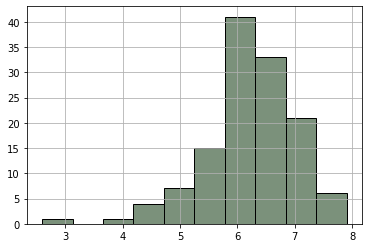

In [14]:
drama["IMDB Score"].hist(color = "#7B917B", edgecolor = "black")

> **Не очень серьезное отступление.** С одной из групп вспомнили про любопытный ресурс [colorscheme.ru](https://colorscheme.ru/color-names.html) с названиями цветов. Какие-то из них стандартные (включая закрепленные за брендами цвета), какие-то довольно экзотические. Так, здесь цвет первой гистограммы – *цвет влюбленной жабы*, цвет второй гистограммы – *лягушка в обмороке*.

Видно, что распределения не совсем похожи на нормальные: у первого довольно острый пик, второе немного скошено влево. Но, тем не менее, каких-то радикальных отличий от симметричного колокообразного распределения нет. Даже если извлекать случайные выборки объема 100-200 из нормального распределения, можно получить что-то «неидеальное». Объем выборок здесь тоже вполне разумный:

In [15]:
print(comedy.shape[0])
print(drama.shape[0])

141
129


Применяем t-критерий Стьюдента для двух независимых выборок:

In [16]:
st.ttest_ind(drama["IMDB Score"], comedy["IMDB Score"])

Ttest_indResult(statistic=4.574585405739631, pvalue=7.301182973261403e-06)

P-value очень мало, почти 0, нулевая гипотеза о равенстве средних отвергается, средний рейтинг драм отличается от среднего рейтинга комедий. Наблюдаемое значение статистики $t_{\text{набл}}$ равно 4.57, больше 0, значит, средний рейтинг драм выше. Проверим:

In [17]:
print("Drama:", drama["IMDB Score"].mean())
print("Comedy:", comedy["IMDB Score"].mean())

Drama: 6.260465116279071
Comedy: 5.82340425531915


Действительно, драмы, в среднем, получают более высокие оценки. Что интересно, разница выборочных средних примерно в 0.5 балла оказалась достаточной, чтобы отвергнуть гипотезу о равенстве средних. 

Теперь попробуем проверить гипотезу о том, что средняя продолжительность фильмов равна 90 минутам. Применим одновыборочный t-критерий Стьюдента:

In [18]:
st.ttest_1samp(films["Runtime"], popmean = 90)

Ttest_1sampResult(statistic=3.1443197872657156, pvalue=0.0017494339713071045)

Вновь гипотеза отвергается, средняя продолжительность фильмов не равна 90 минутам (p-value меньше любого конвенционального уровня значимости, даже менее 1%). Но с продолжительностью фильма тут все сложно: очень разные фильмы собраны в выборке. Посмотрим на описательные статистики:

In [19]:
films["Runtime"].describe()

count    584.00000
mean      93.60274
std       27.68934
min        4.00000
25%       86.00000
50%       97.00000
75%      107.00000
max      209.00000
Name: Runtime, dtype: float64

Стандартное отклонение очень большое, при описании данных мы могли бы сказать, что средняя продолжительность фильмов $94\pm28$ минут, разброс значений велик. На гистограмме это тоже видно:

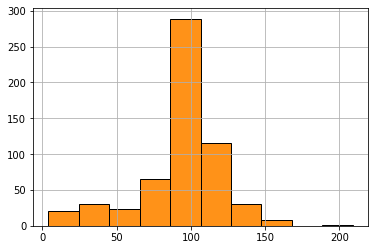

In [20]:
# для кругозора: цвет – последний вздох Жако, 
# такой цвет есть, устаревший, в XIX веке использовался
# перед смертью у попугаев Жако такой цвет глаз

films["Runtime"].hist(color = "#FF9218", edgecolor = "black")

### Выявление связей: качественные данные

Попробуем проверить, есть ли связь между жанром фильма и языком (вполне логично предположить, что связь может быть, так как могут быть специфические локальные жанры). 

Построим таблицу сопряженности с помощью функции `crosstab()` из `pandas`:

In [21]:
tab = pd.crosstab(films["Genre"], films["Language"])
tab

Language,Bengali,Dutch,English,English/Akan,English/Arabic,English/Hindi,English/Japanese,English/Korean,English/Mandarin,English/Russian,...,Portuguese,Spanish,Spanish/Basque,Spanish/Catalan,Spanish/English,Swedish,Tamil,Thai,Thia/English,Turkish
Genre,,,,,,,,,,,,,,,,,,,,,
Action,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Action comedy,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Action thriller,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Action-adventure,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Action-thriller,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
War,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
War drama,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
War-Comedy,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Проблема: таблица сопряженности получилась огромной! 115 строк и 38 столбцов, причем из-за большого числа категорий большинство частот в таблице равны 0 или просто очень маленькие. Чисто технически критерий согласия хи-квадрат применить получится, Python даже не выдаст никаких сообщений с предупреждением, но содержательно это не будет иметь большого смысла. Этот критерий исходит из предположения, что ячеек с маленькими частотами нет или их очень мало. Считается, что доля карликовых ячеек с ожидаемыми частотами менее 5 должна быть не более 5%, ожидаемых частот мы пока не видим, но понятно, что если много 0, ожидаемые частоты тоже будут в районе 0. 

Давайте попробуем применить критерий хи-квадрат и посмотреть, что получится:

In [22]:
st.chi2_contingency(tab)

(2956.2306829330773,
 1.0,
 4218,
 array([[1.19863014e-02, 3.59589041e-02, 4.80650685e+00, ...,
         2.39726027e-02, 1.19863014e-02, 5.99315068e-02],
        [8.56164384e-03, 2.56849315e-02, 3.43321918e+00, ...,
         1.71232877e-02, 8.56164384e-03, 4.28082192e-02],
        [1.71232877e-03, 5.13698630e-03, 6.86643836e-01, ...,
         3.42465753e-03, 1.71232877e-03, 8.56164384e-03],
        ...,
        [1.71232877e-03, 5.13698630e-03, 6.86643836e-01, ...,
         3.42465753e-03, 1.71232877e-03, 8.56164384e-03],
        [5.13698630e-03, 1.54109589e-02, 2.05993151e+00, ...,
         1.02739726e-02, 5.13698630e-03, 2.56849315e-02],
        [1.71232877e-03, 5.13698630e-03, 6.86643836e-01, ...,
         3.42465753e-03, 1.71232877e-03, 8.56164384e-03]]))

Ужасно большое наблюдаемое значение статистики критерия $2956.23$ и огромное число степеней свободы 4218, максимально возможное p-value равное 1. Формально можно сделать вывод, что признаки независимы, но все-таки для корректного анализа нужно укрупнить категории и перейти к более разумной таблице сопряженности.

**Дополнительно для желающих.** Все-таки надо определиться с делением на жанры и создать более общую классификацию. Так как, в первую очередь, нас интересуют фильмы, давайте сначала уберем из датафрейма то, что фильмом не является: `Show`, `Variety show`, `Aftershow / Interview` и `Concert Film`.

In [23]:
# добавляем оператор отрицания ~ перед contains()

films = films[~films["Genre"].str.contains("Show", case = False)]
films = films[~films["Genre"].str.contains("Concert", case = False)]

Давайте оставим основные общепринятые жанры, то есть объединим все имеющиеся жанры в более крупные группы:
    
* Action
* Adventure
* Animation
* Comedy
* Drama
* Fantasy
* Horror
* Musical
* Romance
* Science-fiction
* Thriller
* Western

Чтобы сократить число жанров и разобраться в них, давайте выполним серию последовательных замен. Логика кода ниже: с помощью метода `.loc` отбираем строки, которые в столбце `Genre` содержат определенные слова, и заменяем их на новые значения через присваивание с `=`.

In [24]:
# в loc сначала условие на строки, затем через запятую – на столбцы
# на строки условия ставим через contains()
# на столбцы условия нет, просто указываем название столбца Genre

films.loc[films['Genre'].str.contains('thriller', case = False), 'Genre'] = 'Thriller'
films.loc[films['Genre'].str.contains('musical', case = False), 'Genre'] = 'Musical'
films.loc[films['Genre'].str.contains('action', case = False), 'Genre'] = 'Action'
films.loc[films['Genre'].str.contains('fantasy', case = False), 'Genre'] = 'Fantasy'
films.loc[films['Genre'].str.contains('family', case = False), 'Genre'] = 'Family'

Порядок замен имеет значение. Если, например, у нас есть фильм с жанром *Family musical*, то жанр *Musical* будет главным, мы заменим название жанра на *Musical*, и *Family* уже не останется и при последующих заменах учтено не будет.

Пользуясь этой логикой, разрешим неопределенность с жанрами типа *comedy-drama* и *drama-comedy*. Сначала выполним замену *comedy-drama* на *comedy* и *drama-comedy* на *drama*, так как первое слово важнее:

In [25]:
# дефис после comedy и drama важен, чтобы не зацепить лишнее

films.loc[films['Genre'].str.contains('comedy-', case = False), 'Genre'] = 'Comedy'
films.loc[films['Genre'].str.contains('drama-', case = False), 'Genre'] = 'Drama'

А вот теперь, когда спорных жанров не осталось, можем все остальные жанры с *comedy* и *drama* в составе заменить:

In [26]:
films.loc[films['Genre'].str.contains('comedy', case = False), 'Genre'] = 'Comedy'
films.loc[films['Genre'].str.contains('drama', case = False), 'Genre'] = 'Drama'

Посмотрим на список жанров:

In [27]:
films["Genre"].unique()

array(['Documentary', 'Thriller', 'Drama', 'Mystery', 'Action', 'Comedy',
       'Musical', 'Horror anthology', 'Horror', 'Anime / Short',
       'Superhero', 'Heist', 'Western', 'Animation/Superhero', 'Family',
       'Animation', 'Science fiction adventure', 'Science fiction',
       'Fantasy', 'Science fiction/Mystery', 'Romance', 'Biopic',
       'Mockumentary', 'Satire', 'Zombie/Heist', 'Psychological horror',
       'Sports film', 'Adventure-romance', 'Adventure', 'Stop Motion',
       'War', 'Animation / Musicial', 'Anime/Science fiction',
       'Animation / Short', 'Historical-epic', 'Mentalism special',
       'Making-of', 'Animation / Science Fiction'], dtype=object)

Ура, список жанров сократился! Давайте жанр *Mystery* объединим с *Fantasy*, *Horror* с *Horror anthology* и *Psychological horror*, *Adventure* с *Adventure-romance*, *Science fiction* с *Science fiction adventure* и *Science fiction/Mystery*:

In [28]:
# делаем обычную замену через replace()
# старое название на первом месте, новое – на втором

films["Genre"] = films["Genre"].replace("Mystery", "Fantasy")
films["Genre"] = films["Genre"].replace("Horror anthology", "Horror")
films["Genre"] = films["Genre"].replace("Psychological horror", "Horror")
films["Genre"] = films["Genre"].replace("Adventure-romance", "Adventure")
films["Genre"] = films["Genre"].replace("Science fiction adventure", "Science fiction")
films["Genre"] = films["Genre"].replace("Science fiction/Mystery", "Science fiction")

Выведем таблицу частот:

In [29]:
films["Genre"].value_counts()

Documentary                    159
Comedy                         126
Drama                          110
Thriller                        58
Action                          17
Musical                         13
Horror                          11
Biopic                           9
Fantasy                          7
Science fiction                  6
Romance                          6
Family                           5
Animation                        5
Animation / Short                4
Western                          3
Adventure                        3
Making-of                        2
Superhero                        2
Mockumentary                     2
Satire                           2
Anime/Science fiction            2
War                              2
Animation / Musicial             1
Mentalism special                1
Historical-epic                  1
Sports film                      1
Stop Motion                      1
Animation/Superhero              1
Zombie/Heist        

Предлагаю оставить *Biopic* как отдельный жанр, а все, что встречается 6 раз и меньше объединить в категорию *Other*:

In [30]:
# сохраняем таблицу частот в freqs
# отбираем в ней строки с частотой <= 6
# забираем названия – index – и превращаем в список

freqs = films["Genre"].value_counts()
other = list(freqs[freqs <= 6].index)
print(other)

['Science fiction', 'Romance', 'Family', 'Animation', 'Animation / Short', 'Western', 'Adventure', 'Making-of', 'Superhero', 'Mockumentary', 'Satire', 'Anime/Science fiction', 'War', 'Animation / Musicial', 'Mentalism special', 'Historical-epic', 'Sports film', 'Stop Motion', 'Animation/Superhero', 'Zombie/Heist', 'Anime / Short', 'Heist', 'Animation / Science Fiction']


Воспользуемся методом `.isin()`, который проверяет вхождение в список, и методом `.loc` по той же схеме, которую мы использовали выше для замены с `.contains()`:

In [31]:
# условие на строки через .isin(other)
# условия на столбцы нет, название Genre

films.loc[films['Genre'].isin(other), 'Genre'] = 'Other'

Проверяем, что получилось:

In [32]:
films["Genre"].value_counts()

Documentary    159
Comedy         126
Drama          110
Thriller        58
Other           54
Action          17
Musical         13
Horror          11
Biopic           9
Fantasy          7
Name: Genre, dtype: int64

Годится! Осталось поработать с языками. Но тут проще: давайте все сочетания языков, которые начинаются с *English* переименуем в *English*, так как вначале обычно указывается основной язык:

In [33]:
# схема та же, только метод startswith()

films.loc[films['Language'].str.startswith('English'), 'Language'] = 'English'

То же делаем для испанского:

In [34]:
films.loc[films['Language'].str.startswith('Spanish'), 'Language'] = 'Spanish'

Проверяем:

In [35]:
films["Language"].value_counts()

English                 399
Spanish                  34
Hindi                    33
French                   20
Italian                  14
Portuguese               12
Indonesian                9
Japanese                  6
Korean                    6
German                    5
Turkish                   5
Dutch                     3
Polish                    3
Marathi                   3
Filipino                  2
Thai                      2
Malay                     1
Norwegian                 1
Swedish                   1
Thia/English              1
Georgian                  1
Bengali                   1
Khmer/English/French      1
Tamil                     1
Name: Language, dtype: int64

Давайте проделаем то же самое, что с жанрами, объединим редкие значения в категорию *Other*:

In [36]:
freqs_lang = films["Language"].value_counts()
other2 = list(freqs_lang[freqs_lang <= 5].index)
print(other2)

['German', 'Turkish', 'Dutch', 'Polish', 'Marathi', 'Filipino', 'Thai', 'Malay', 'Norwegian', 'Swedish', 'Thia/English', 'Georgian', 'Bengali', 'Khmer/English/French', 'Tamil']


In [37]:
films.loc[films['Language'].isin(other2), 'Language'] = 'Other'

Готово! Сформируем новую таблицу сопряженности:

In [38]:
tab_new = pd.crosstab(films["Genre"], films["Language"])
tab_new

Language,English,French,Hindi,Indonesian,Italian,Japanese,Korean,Other,Portuguese,Spanish
Genre,,,,,,,,,,
Action,13,2,1,0,0,0,0,1,0,0
Biopic,8,0,0,0,1,0,0,0,0,0
Comedy,86,4,10,3,3,0,1,6,8,5
Documentary,134,6,0,0,0,1,1,4,3,10
Drama,56,4,14,5,9,1,2,10,0,9
Fantasy,4,0,1,0,0,1,0,1,0,0
Horror,6,0,2,0,0,0,0,3,0,0
Musical,12,0,0,0,0,0,0,0,0,1
Other,44,0,0,0,1,2,1,2,1,3


В этой таблице тоже есть ячейки с небольшими значениями, но все уже не так критично. Применим критерий согласия хи-квадрат:

In [41]:
st.chi2_contingency(tab_new)

(143.6202435050016,
 2.268775021578315e-05,
 81,
 array([[1.20265957e+01, 6.02836879e-01, 9.94680851e-01, 2.71276596e-01,
         4.21985816e-01, 1.80851064e-01, 1.80851064e-01, 9.34397163e-01,
         3.61702128e-01, 1.02482270e+00],
        [6.36702128e+00, 3.19148936e-01, 5.26595745e-01, 1.43617021e-01,
         2.23404255e-01, 9.57446809e-02, 9.57446809e-02, 4.94680851e-01,
         1.91489362e-01, 5.42553191e-01],
        [8.91382979e+01, 4.46808511e+00, 7.37234043e+00, 2.01063830e+00,
         3.12765957e+00, 1.34042553e+00, 1.34042553e+00, 6.92553191e+00,
         2.68085106e+00, 7.59574468e+00],
        [1.12484043e+02, 5.63829787e+00, 9.30319149e+00, 2.53723404e+00,
         3.94680851e+00, 1.69148936e+00, 1.69148936e+00, 8.73936170e+00,
         3.38297872e+00, 9.58510638e+00],
        [7.78191489e+01, 3.90070922e+00, 6.43617021e+00, 1.75531915e+00,
         2.73049645e+00, 1.17021277e+00, 1.17021277e+00, 6.04609929e+00,
         2.34042553e+00, 6.63120567e+00],
        [4.

P-value близко к 0, гипотеза о независимости признаков отвергается, связь все же есть! Не то что бы очевидная, в данных просто много фильмов на английском, но, например, среди фильмов на хинди больше всего драм, а среди фильмов на испанском часто встречаются документальные фильмы.

### Выявление связей: количественные данные

Чтобы вернуть датафрейму `films` исходный вид (в дополнительном материале выше была фильтрация), загрузим файл еще раз и выполним замену пропусков – повторение кода из первой части:

In [42]:
films = pd.read_csv("Netflix.csv")
films["Runtime"] = films["Runtime"].fillna(films["Runtime"].median())
films["IMDB Score"] = films["IMDB Score"].fillna(films["IMDB Score"].median())

Построим корреляцию матрицу для `films`:

In [43]:
# или films.corr(numeric_only = True)

films.corr()

,Runtime,IMDB Score
Runtime,1.000000,-0.033208
IMDB Score,-0.033208,1.000000


Связь между продолжительностью фильма и его рейтингом очень слабая, коэффициент корреляции Пирсона близок к нулю. Вывод: либо связи действительно почти нет, либо она нелинейная. Посмотрим на диаграмму рассеивания:

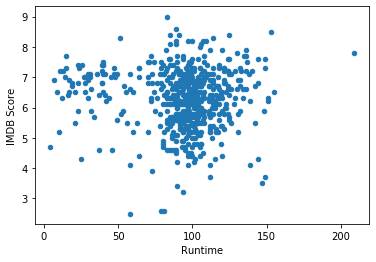

In [44]:
films.plot.scatter(x = "Runtime", y = "IMDB Score");

Судя по всему, связи действительно нет, каких-то намеков на нелинейность или на наличие связи в определенных группах нет. 

Последняя задача – давайте проверим, есть ли связь между годом выхода фильма и его рейтингом. Для этого нам сначала потребуется извлечь год из даты премьеры:

In [45]:
films["Premiere"]

0         August 5, 2019
1        August 21, 2020
2      December 26, 2019
3       January 19, 2018
4       October 30, 2020
             ...        
579    December 31, 2018
580      October 9, 2015
581    December 16, 2018
582     December 8, 2020
583      October 4, 2020
Name: Premiere, Length: 584, dtype: object

Воспользуемся методом `.split()` из подмодуля `str` и разобьем дату по запятой:

In [46]:
# на выходе – новый столбец со списками

films["Premiere"].str.split(",")

0         [August 5,  2019]
1        [August 21,  2020]
2      [December 26,  2019]
3       [January 19,  2018]
4       [October 30,  2020]
               ...         
579    [December 31,  2018]
580      [October 9,  2015]
581    [December 16,  2018]
582     [December 8,  2020]
583      [October 4,  2020]
Name: Premiere, Length: 584, dtype: object

Со списками внутри столбца работать не очень удобно, «растянем» списки на несколько столбцов:

In [47]:
# expand = True –  вместо столбца со списками несколько столбцов

films["Premiere"].str.split(",", expand = True)

,0,1
0,August 5,2019
1,August 21,2020
2,December 26,2019
3,January 19,2018
4,October 30,2020
...,...,...
579,December 31,2018
580,October 9,2015
581,December 16,2018
582,December 8,2020


Заберем только столбец с годом – столбец с индексом 1 – и превратим его в числовой:

In [48]:
films["Year"] = films["Premiere"].str.split(",", expand = True)[1].astype(float)

Почему в `.astype()` мы указали тип `float`, если год всегда целочисленный? В столбце 1 почему-то образовались пропуски, а числовой столбец с пропусками всегда будет типом `float`, тип `integer` их не поддерживает. Посмотрим, в каких фильмах вместо года образовались пропущенные значения:

In [49]:
films[films["Year"].isnull()]

,Title,Genre,Premiere,Runtime,IMDB Score,Language,Year
111,Ghosts of Sugar Land,Documentary,October 16. 2019,21.0,5.5,English,NaN
308,Strong Island,Documentary,September 15. 2017,107.0,6.4,English,NaN
387,Tony Robbins: I Am Not Your Guru,Documentary,July 15. 2016,116.0,6.7,English,NaN
538,Joan Didion: The Center Will Not Hold,Documentary,October 27. 2017,98.0,7.5,English,NaN
541,The White Helmets,Documentary,September 16. 2016,40.0,7.5,English,NaN


Проблема была в том, что в столбце `Premiere` были даты с точкой вместо запятой. Чуть позже можем заменить точки на запятые и повторить манипуляции с годами, чтобы не потерять эти пять фильмов, пока их просто проигнорируем:

In [50]:
# удаляем пропуски – кроме NaN в Year больше нигде нет,
# больше ничего не теряем

films.dropna(inplace = True)

Вычислим коэффициент Пирсона и проверим его значимость:

In [51]:
st.pearsonr(films["Year"], films["IMDB Score"])

(-0.1350366145961721, 0.0011251064726095251)

Коэффициент Пирсона $-0.14$, отрицательный, небольшой по модулю, связь обратная и слабая. Однако, статистически значимая на 5%-ном и даже 1%-ном уровне значимости, p-value примерно 0.001. Более новые фильмы получают более низкие оценки, но эта тенденция не очень яркая. 

В целом, коэффициент корреляции Спирмена здесь тоже подойдет – год нельзя считать порядковой шкалой, но набор значений ограничен:

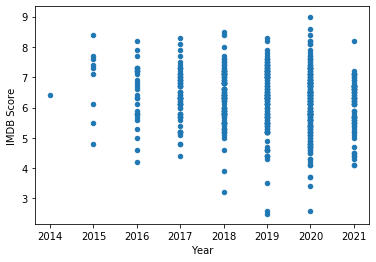

In [52]:
films.plot.scatter(x = "Year", y = "IMDB Score");

Однако существенных отличий от предыдущих результатов мы не увидим:

In [53]:
st.spearmanr(films["Year"], films["IMDB Score"])

SpearmanrResult(correlation=-0.13159287127656455, pvalue=0.0015065948139173007)

**Дополнительно для желающих.** Если не хотим потерять фильмы с другим форматом даты премьеры, выполним замену точку на запятую, а потом произведем разбиение и извлечение года. Так как ранее строки с пропусками мы уже удалили, загрузим файл еще раз и выполним преобразования из первой части практикума:

In [54]:
films = pd.read_csv("Netflix.csv")
films["Runtime"] = films["Runtime"].fillna(films["Runtime"].median())
films["IMDB Score"] = films["IMDB Score"].fillna(films["IMDB Score"].median())

Заменяем `.` на `,` , при этом используем не обычный `.replace()`, а `.replace()` из `str`. Обычный `.replace()` будет искать ячейки, равные `.`, а вариант из `str` будет искать `.` в тексте внутри ячеек и выполнять замену при необходимости:

In [55]:
films["Premiere"] = films["Premiere"].str.replace(".", ",")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


Пропусков уже быть не должно, столбец можно сделать типом `int`:

In [56]:
films["Year"] = films["Premiere"].str.split(",", expand = True)[1].astype(int)

In [57]:
films["Year"].isnull().sum()

0